In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


SEED = 456
PATH = ""

In [2]:
restaurants = pd.read_csv(PATH + "Data/nyc_restaurants.csv", index_col = [0])
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23536 entries, 0 to 23535
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CAMIS                          23536 non-null  int64  
 1   DBA                            23536 non-null  object 
 2   BORO                           23536 non-null  object 
 3   BUILDING                       23536 non-null  object 
 4   STREET                         23536 non-null  object 
 5   ZIPCODE                        23536 non-null  float64
 6   PHONE                          23536 non-null  object 
 7   CUISINE DESCRIPTION            23536 non-null  object 
 8   INSPECTION DATE                23536 non-null  object 
 9   ACTION                         23536 non-null  object 
 10  VIOLATION CODE                 23536 non-null  object 
 11  VIOLATION DESCRIPTION          23536 non-null  object 
 12  CRITICAL FLAG                  23536 non-null  obje

In [3]:
restaurants["POST COVID"] = restaurants["POST COVID"].astype(str)
restaurants["RISKY BUSINESS"] = restaurants["RISKY BUSINESS"].astype(str)

In [4]:
restaurants.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'INSPECTION TYPE',
       'Latitude', 'Longitude', 'INSPECTION PURPOSE', 'GRADED', 'POST COVID',
       'CRITICAL FLAGS PER INSPECTION', 'VIOLATIONS PER INSPECTION',
       'DAYS SINCE LAST INSPECTION', 'YEAR', 'MONTH', 'DAY', 'CLOSED',
       'LOCATION COUNT', 'TOTAL INSPECTIONS', 'RISKY BUSINESS',
       'MONTHS OPERATING', 'AVERAGE VIOLATIONS', 'AVERAGE CRITICAL FLAGS',
       'AVERAGE SCORE', 'YEARS'],
      dtype='object')

In [5]:
y = restaurants[["RISKY BUSINESS"]]
X = restaurants.drop(["CAMIS", "DBA", "INSPECTION DATE", "BUILDING", "STREET", "ZIPCODE", "PHONE", "ACTION", 
                       "INSPECTION TYPE", "SCORE", "VIOLATION CODE", "VIOLATION DESCRIPTION", "Latitude", "Longitude", 
                       "CRITICAL FLAG", "GRADED", "CRITICAL FLAGS PER INSPECTION", "VIOLATIONS PER INSPECTION", "YEARS",
                       "RISKY BUSINESS"], axis = 1)

X = pd.get_dummies(X, dtype = int)
# note: don't use inspection type column - restaurants have inspections before tracked in dataset 
# (pre-premit only useful for new restaurants)

In [6]:
y["RISKY BUSINESS"].value_counts()

400/23136

0.017289073305670817

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = SEED)

<Axes: >

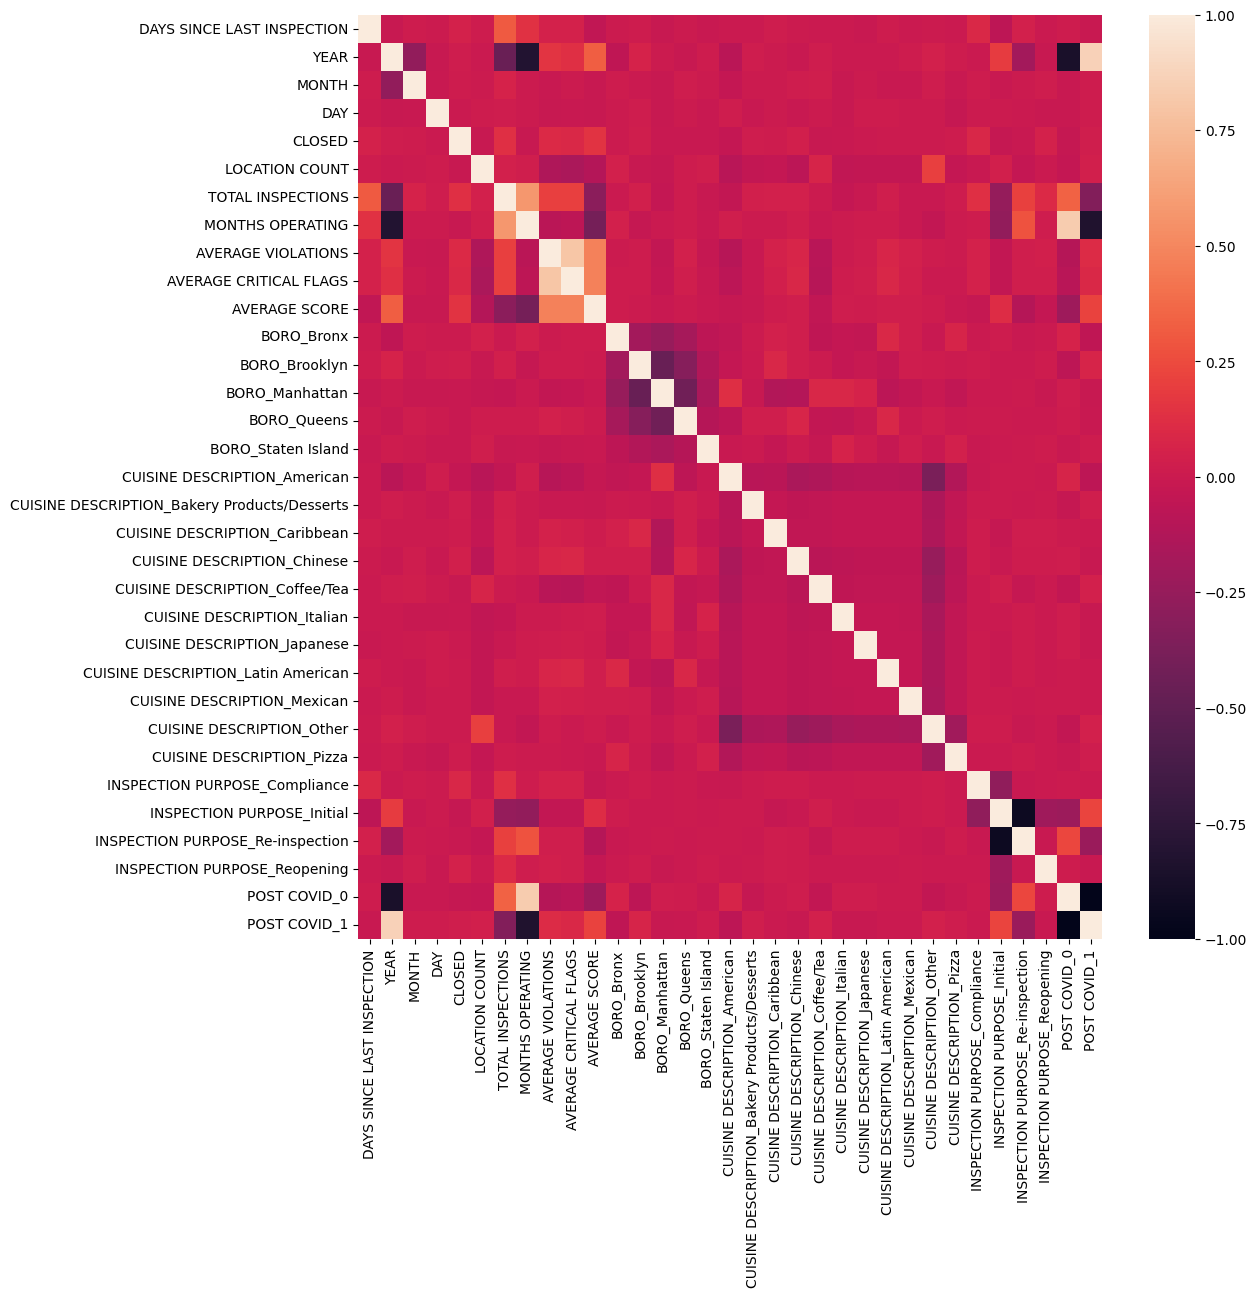

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(X_train.corr())

## Anomaly Detection (Risk)

In [9]:
# anomaly detection 

### Isolation Forest

In [10]:
#isof_params = {'contamination':('auto', 0.02), 'max_features':[0.5, 0.75, 1.0]}
#isof = IsolationForest(n_estimators = 100, bootstrap = True, random_state = SEED)
#iso_forest = GridSearchCV(isof, isof_params, return_train_score = True, scoring = 'f1_weighted')
iso_forest_auto = IsolationForest(n_estimators = 100, max_features = 0.5, bootstrap = True, contamination = 'auto', random_state = SEED)
iso_forest_auto.fit(X_train)
iso_pred_auto = iso_forest_auto.predict(X_test)

# for parameter grid -
# contamination = auto or 0.02
# max_features (16 total) = 0.5, 0.75, 1.0
# n_estimators varying?
# bootstrap true - because less than 2% of data considered outliers by risk metric

iso_forest = IsolationForest(n_estimators = 100, max_features = 0.5, bootstrap = True, contamination = 0.02, random_state = SEED)
iso_forest.fit(X_train)
iso_pred = iso_forest.predict(X_test)

# The refitted estimator is made available at the best_estimator_ attribute and 
# permits using predict directly on this GridSearchCV instance.
# Return_train_score? T/F?
# scoring = ?

In [11]:
print(pd.Series(iso_pred_auto).value_counts())
print(pd.Series(iso_pred).value_counts())
y_test.value_counts()

 1    4375
-1     333
Name: count, dtype: int64
 1    4617
-1      91
Name: count, dtype: int64


RISKY BUSINESS
0                 4628
1                   80
Name: count, dtype: int64

From general exploration using the isolation forest, 333 points marked as outliers (without coersion from contamination parameter). 
There is very likely some variable or combination of variables that weed out certain observations as outliers - suggesting outliers are present in the data.

In [12]:
outlier_idx = np.where(pd.Series(iso_forest.decision_function(X_test)) < 0)
# negative scores = outliers, lower = more abnormal

y_test.iloc[outlier_idx].value_counts()

RISKY BUSINESS
0                 87
1                  4
Name: count, dtype: int64

In [13]:
outlier_idx2 = np.where(pd.Series(iso_forest_auto.decision_function(X_test)) < 0)
# negative scores = outliers, lower = more abnormal

y_test.iloc[outlier_idx2].value_counts()

RISKY BUSINESS
0                 318
1                  15
Name: count, dtype: int64

Do not appear to align very closely with determinants of risk variable (# inspections over time in data).

### One Class SVM 

### 

In [14]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(nu = 0.02, gamma = 'auto')
ocsvm.fit(X_train)

ocsvm_pred = ocsvm.predict(X_test)
ocsvm_pred = pd.Series([1 if i==-1 else 0 for i in ocsvm_pred]).astype(str)
ocsvm_pred


0       0
1       0
2       0
3       0
4       0
       ..
4703    0
4704    0
4705    0
4706    0
4707    0
Length: 4708, dtype: object

In [15]:
ocsvm_pred.value_counts()

0    3998
1     710
Name: count, dtype: int64

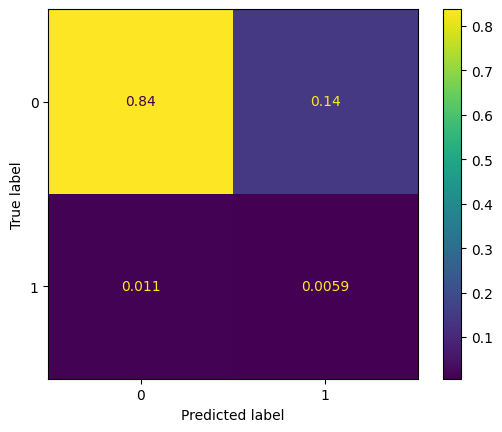

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test["RISKY BUSINESS"], ocsvm_pred, normalize = 'all')

~ 2% of data considered high risk - only 0.59% correctly predicted, and 14% predicted high risk, but were not, 
so the model is overflagging restaurants as high risk.

### PCA

In [17]:
scaler = StandardScaler()

cols = X_train.columns[0:11]
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train[cols]), columns = cols)
X_train_left = X_train.drop(cols, axis = 1)
X_train_scale = pd.merge(X_train_scale, X_train_left, left_index = True, right_index = True)

X_test_scale = pd.DataFrame(scaler.transform(X_test[cols]), columns = cols)
X_test_left = X_test.drop(cols, axis = 1)
X_test_scale = pd.merge(X_test_scale, X_test_left, left_index = True, right_index = True)

In [18]:
pca = PCA(n_components = 2)

principal_components = pd.DataFrame(pca.fit_transform(X_train_scale), columns = ["PC1", "PC2"])
principal_components["RISKY BUSINESS"] = y_train[["RISKY BUSINESS"]]
pca.explained_variance_ratio_

array([0.20444707, 0.16141473])

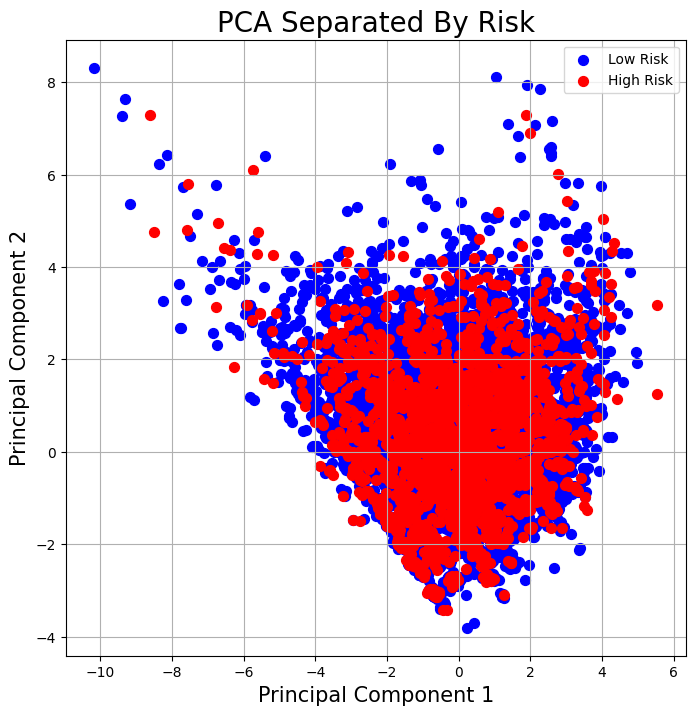

In [19]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel("Principal Component 1", fontsize = 15)
ax.set_ylabel("Principal Component 2", fontsize = 15)
ax.set_title("PCA Separated By Risk", fontsize = 20)

principal_components["RISKY BUSINESS"] = principal_components["RISKY BUSINESS"].fillna("High Risk")
principal_components["RISKY BUSINESS"] = principal_components["RISKY BUSINESS"].replace({"0":"Low Risk", 
                                                                                         "1":"High Risk"})

targets = ["Low Risk", "High Risk"]
colors = ['b', 'r']
for target, color in zip(targets, colors):
    indicesToKeep = principal_components["RISKY BUSINESS"] == target
    ax.scatter(principal_components.loc[indicesToKeep, 'PC1'], principal_components.loc[indicesToKeep, 'PC2'], 
               c = color, s = 50)
ax.legend(targets)
ax.grid()

There is no distingishing high and low risk restaurants using the created risk variable with PCA.
Even the first principal component only explains 20% of variance in the data - so no combination of these variables 
give much insight into the variation between restaurants as a whole.